# ML FOR EEG SIGNAL PROCESSING

In [ ]:
import scipy.io
from itertools import chain
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import math

We load the 2 datasets for human and piano pictures as below:

In [2]:
from google.colab import drive
drive.mount('/content/drive')
mat_1 = scipy.io.loadmat(r'/content/drive/MyDrive/S2T2B1.mat')
mat_2 = scipy.io.loadmat(r'/content/drive/MyDrive/S2T2B2.mat')

Mounted at /content/drive


Here are some general explanations regarding **feature extraction** from the data:

A feature represents a distinguishing property, a recognizable measurement, and a functional component obtained from a section of a pattern.


Extracted features are meant to **minimize the loss** of important information embedded in the signal. In addition, they also simplify the amount of resources needed to describe a huge set of data accurately. This is necessary to **minimize the complexity** of implementation to reduce the cost of information processing, and to cancel the potential need to compress the information.


A variety of methods have been widely used to extract the features from EEG signals. Among these methods are **Time Frequency Distributions (TFD)**, **Fast Fourier Transform (FFT)**, **Eigenvector Methods (EM)**, **Wavelet Transform (WT)**, and **Auto Regressive Method (ARM)**.


Acclaim about the definite priority of methods according to their capability is very hard. The findings indicate that each method has specific advantages and disadvantages, which make it appropriate for special type of signals.


Frequency domain methods may not provide high-quality performance for some EEG signals. In contrast, time-frequency methods, for instance, may not provide detailed information on EEG analysis as much as frequency domain methods. It is crucial to make clear the of the signal to be analyzed in the application of the method whenever the performance of analyzing method is discussed.


In this project, we used the method of dividing the data into different **overlapping windows**, as a method for feature selection. The overlapping windows were implemented as below:

In [3]:
num_trials = len(mat_1['a'])
num_channels = len(mat_1['a'][0])

def create_window (mat_1,num_trials,num_channels):
    windowed_data = []
    for i in range (num_trials):
        for j in range (num_channels):
            for k in range(0,3500,50):
                a = sum(mat_1['a'][i,j,k:k+70])/70
                windowed_data.append(a)
    windowed_data = np.reshape(windowed_data, (45,126,70))
    return windowed_data


windowed_data_1 = create_window (mat_1,num_trials,num_channels)
windowed_data_2 = create_window (mat_2,num_trials,num_channels)

We put the data into **pandas dataframe** formats and concate the piano and human labels into 1 dataframe.
We separate the dataframes for each of the 70 time slots that we have, so finally we have 70 dataframes with 126x90 rows each.

In [4]:
def create_dataframes(mat, label):
    dataframes = []
    for i in range (70):
        flatten_list = list(chain.from_iterable(mat[:,:,i]))
        df = pd.DataFrame(flatten_list)
        df['label'] = label
        dataframes.append(df)
    return(dataframes)

human_dataframes = create_dataframes(windowed_data_1, 'human') 
piano_dataframes = create_dataframes(windowed_data_2, 'piano') 

dataframes = []
for i in range (70):
    dataframes.append(pd.concat([human_dataframes[i], piano_dataframes[i]]))


**Preprocessing:**
We shuffle our data frame, split it into test and train datasets , and use standardscaler and random seed on our test and train data. standardscaler moves the mean to 0 and scales the variance to 1.

**Classification Model:**
For classification, we have 3 classification models. **KNN, SVM,** and **Neural Networks(MLP)**.


**K-Nearest Neighbors (KNN):**
The K-nearest neighbor (KNN) algorithm is one of the simplest and earliest classification algorithms. The KNN algorithm does not require to consider probability values. The ‘K’ is the KNN algorithm is the number of nearest neighbors considered to take ‘vote’ from. The selection of different values for ‘K’ can generate different classification results for the same sample object.


**Support vector machine (SVM):**
Support vector machine (SVM) algorithm can classify both linear and non-linear data. It first maps each data item into an n-dimensional feature space where n is the number of features. It then identifies the hyperplane that separates the data items into two classes while maximizing the marginal distance for both classes and minimizing the classification errors.


**MLP (Neural Networks):**
Neural Networks are a set of machine learning algorithms which are inspired by the functioning of the neural networks of human brain. Likewise, NN algorithms can be represented as an interconnected group of nodes. The output of one node goes as input to another node for subsequent processing according to the interconnection. Nodes are normally grouped into a matrix called layer depending on the transformation they perform. Nodes and edges have weights that enable to adjust signal strengths of communication which can be amplified or weakened through repeated training. Based on the training and subsequent adaption of the matrices, node and edge weights, NNs can make a prediction for the test data.


**Cross Validation:**

We implement the 3 models discussed above in different functions. We use **GridSearchCV** that is a type of **K-fold cross validation** method to find the hyperparameters. After finding the best hyperparameters, we trained our model, evaluated it on test data, and returned the **test accuracy**.


In [5]:
def classification_svm(df,seed_num):
    np.random.seed(seed_num)

    df= df.sample(frac=1)
    y=df['label']
    x=df.drop('label', axis = 1)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
    scaler = StandardScaler().fit(x_train)
    x_train = scaler.transform(x_train)
    scaler = StandardScaler().fit(x_test)
    x_test =scaler.transform(x_test)
    clf_svm = SVC(kernel='rbf',gamma='auto'  )
    clf_svm.fit(x_train,y_train)
    pred_test=clf_svm.predict(x_test)
    score_test = accuracy_score(pred_test, y_test)
    return score_test

In [6]:
def classification_mlp(df,seed_num):
    np.random.seed(seed_num)

    df= df.sample(frac=1)
    y=df['label']
    x=df.drop('label', axis = 1)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
    scaler = StandardScaler().fit(x_train)
    x_train = scaler.transform(x_train)
    scaler = StandardScaler().fit(x_test)
    x_test =scaler.transform(x_test)
    clf_mlp = MLPClassifier( learning_rate='adaptive',max_iter=1000,activation='relu',solver='adam',hidden_layer_sizes=375)
    clf_mlp.fit(x_train,y_train)
    pred_test = clf_mlp.predict(x_test)
    score_test = accuracy_score(pred_test, y_test)
    return score_test

In [7]:
def classification_knn(df,seed_num):
    np.random.seed(seed_num)

    df= df.sample(frac=1)
    y=df['label']
    x=df.drop('label', axis = 1)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
    scaler = StandardScaler().fit(x_train)
    x_train = scaler.transform(x_train)
    scaler = StandardScaler().fit(x_test)
    x_test =scaler.transform(x_test)
    knn = KNeighborsClassifier( weights='distance',algorithm='auto',metric='manhattan')
    param_grid = {'n_neighbors':np.arange(1,50)}
    gs = GridSearchCV(estimator=knn, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=3)
    gs.fit(x_train,y_train)
    gs.best_estimator_.fit(x_train,y_train) 
    pred_test = gs.best_estimator_.predict(x_test)
    score_test = accuracy_score(pred_test, y_test)
    return score_test

We define a function called "Repeated_Classification". It classifies a dataframe 5 times with the selected model.


We defined a function called "Repeated_Classification". It classifies a dataframe 5 times with the selected model. To achive better accuracy, we use 5 different random seed numbers to classify the dataframe 5 times. For each dataframe, we get the mean and the standard deviation of the accuracies. We return a list of accuracy means and a list of accuracy stds:


In [8]:
def Repeated_Classification(df,classifier_nam):
    accuracy_list=[]
    if classifier_nam=="mlp":
      for i in range(1,6):
         seed_num=i*10
         accuracy_list.append(classification_mlp(df,seed_num))
    elif classifier_nam=="svm":
      for i in range(1,6):
         seed_num=i*10
         accuracy_list.append(classification_svm(df,seed_num))
    else:
      for i in range(1,6):
         seed_num=i*10
         accuracy_list.append(classification_knn(df,seed_num))
       
    accuracy_list=np.array(accuracy_list)
    accuracy_mean=np.mean(accuracy_list)
    accuracy_std=np.std(accuracy_list)
    return accuracy_mean,accuracy_std

We define a function called "plot_accuracy". It gets the list of **accuracy_mean** and **accuracy_stds**, plots the classification accuracy during time, and reports the best accuracy.


We plot the mean accuracy and the standard error band: SE=(std)/(N^0.5)


N: number of samples


std: sample standard deviation


SE:standard error of the sample


So the maximum value of the band is mean+SE and the minimum value of the band is mean-SE.


We also mapped the number of our dataframes in time. For each dataframe, we flattend the mean of the window with the length of 70 samples. So for each dataframe, we converted the number of its middle samples to milliseconds:


The samples of the k_th dataframe vary from 50k to 50k+70, so the middle sample index is (50k+50k+70)/2=50k+35.


In [9]:
def plot_accuracy(accuracy_mean_list,accuracy_std_list):
  accuracy_mean_list_percent=np.array(accuracy_mean_list)*100
  accuracy_std_list_percent=(np.array(accuracy_std_list)/(5**0.5))*100
  t = np.arange(len(accuracy_mean_list_percent))*100+70
  max_accuracy=max(accuracy_mean_list_percent)
  max_accuracy_index=np.argmax(accuracy_mean_list_percent)
  max_time=t[max_accuracy_index]
  print("max accuracy: "+str(max_accuracy)+" % at "+str(max_time)+" ms")
  plt.plot(t, accuracy_mean_list_percent, 'b-', label='accuracy_mean')
  plt.fill_between(t, accuracy_mean_list_percent - accuracy_std_list_percent, accuracy_mean_list_percent + accuracy_std_list_percent, color='b', alpha=0.2)
  plt.xlabel("time[ms]")
  plt.ylabel("accuracy")
  plt.title("Classification accuracy with SE band")
  plt.show()

MLP:

In [10]:
accuracy_mean_list=[]
accuracy_std_list=[]
for df in (dataframes):
    mean_tamp,std_temp=Repeated_Classification(df,"mlp")
    accuracy_mean_list.append(mean_tamp)
    accuracy_std_list.append(std_temp)

max accuracy: 55.98471487360376 % at 4470 ms


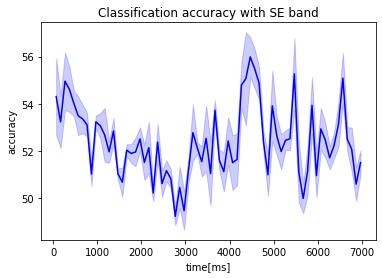

In [11]:
plot_accuracy(accuracy_mean_list,accuracy_std_list)

As we can see at 4.447s we got the maximum accuracy, which means in that time the brain distinguished whether the picture is a piano or a human.

SVM:

In [ ]:
accuracy_mean_list=[]
accuracy_std_list=[]
for df in (dataframes):
    mean_tamp,std_temp=Repeated_Classification(df,"svm")
    accuracy_mean_list.append(mean_tamp)
    accuracy_std_list.append(std_temp)

max accuracy: 57.91887125220458 % at 4470 ms


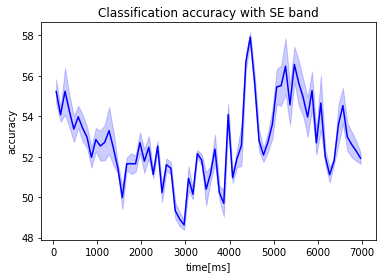

In [ ]:
plot_accuracy(accuracy_mean_list,accuracy_std_list)

As we can see at 4.447s we got the maximum accuracy, which means in that time the brain distinguished whether the picture is a piano or a human.

KNN:

In [ ]:
accuracy_mean_list=[]
accuracy_std_list=[]
for df in (dataframes):
    mean_tamp,std_temp=Repeated_Classification(df,"knn")
    accuracy_mean_list.append(mean_tamp)
    accuracy_std_list.append(std_temp)

max accuracy: 54.062316284538504 % at 4470 ms


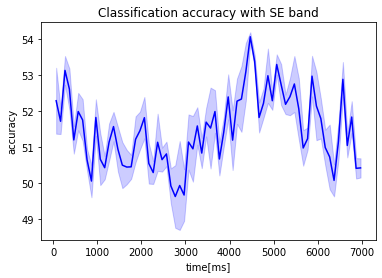

In [ ]:
plot_accuracy(accuracy_mean_list,accuracy_std_list)

As we can see at 4.447s we got the maximum accuracy, which means in that time the brain distinguished whether the picture is a piano or a human.


So we got the same result with different accuracies for our 3 different models, and we found the time that the neurons take to distinguish a picture of a human from a picture of a piano.